0.01 tensor(0.0068) tensor(2.1784)
1.12 tensor(0.7566) tensor(0.3779)
2.23 tensor(1.5064) tensor(0.3773)
3.34 tensor(2.2563) tensor(0.3817)
4.45 tensor(3.0061) tensor(0.4230)
5.5600000000000005 tensor(3.7560) tensor(0.3978)
6.67 tensor(4.5058) tensor(0.3819)
7.78 tensor(5.2557) tensor(0.3429)
8.89 tensor(6.0055) tensor(0.3606)
10.0 tensor(6.7553) tensor(0.4548)
initial_value: Parameter containing:
tensor(0.0676, requires_grad=True)
0 1.5552270412445068 Parameter containing:
tensor(0.1620, requires_grad=True) tensor(-9.4485)
10 0.04877365380525589 Parameter containing:
tensor(0.3886, requires_grad=True) tensor(-0.5914)
20 0.03930824622511864 Parameter containing:
tensor(0.4123, requires_grad=True) tensor(-0.0868)
30 0.03935835510492325 Parameter containing:
tensor(0.4157, requires_grad=True) tensor(-0.0130)
40 0.03904413804411888 Parameter containing:
tensor(0.4163, requires_grad=True) tensor(-0.0022)
50 0.038992732763290405 Parameter containing:
tensor(0.4164, requires_grad=True) tenso

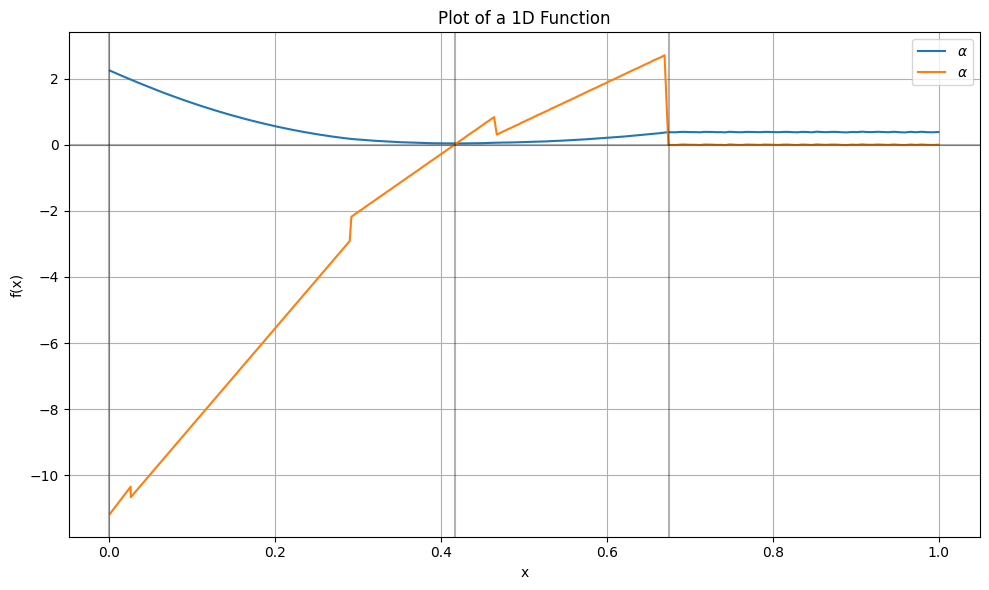

In [59]:
from brevitas.inject import ExtendedInjector
from brevitas.inject.enum import RestrictValueType, ScalingImplType, ScalingPerOutputType, StatsOp
from brevitas.nn import QuantLinear
from brevitas.quant.base import MaxStatsScaling, NarrowIntQuant, PerTensorFloatScaling8bit
from brevitas.quant.solver.weight import WeightQuantSolver


class MyMaxStatsScaling(ExtendedInjector):
    """
    """
    scaling_impl_type = ScalingImplType.PARAMETER_FROM_STATS
    scaling_stats_op = StatsOp.MAX
    scaling_min_val = 1e-10


class PerTensorFloatScaling2bit(ExtendedInjector):
    """
    """
    scaling_per_output_type = ScalingPerOutputType.TENSOR
    restrict_scaling_type = RestrictValueType.FP
    bit_width = 2

class Int2WeightPerTensorFloat(NarrowIntQuant,
                               MyMaxStatsScaling,
                               PerTensorFloatScaling8bit,
                               WeightQuantSolver):
    """
    8-bit narrow per-tensor signed int weight quantizer with per-tensor floating-point scale factor computed
    from backpropagated statistics of the weight tensor.

    Examples:
        >>> from brevitas.nn import QuantLinear
        >>> fc = QuantLinear(10, 5, bias=False, weight_quant=Int8WeightPerTensorFloat)
    """
    pass

linear = QuantLinear(2, 2, weight_quant=Int2WeightPerTensorFloat)
fp_linear = torch.nn.Linear(2,2)
fp_linear.weight.data = linear.weight.data

torch.manual_seed(0)
 
import torch
with torch.no_grad():
    linear(torch.randn(1,2))

input = torch.randn(2,2)

with torch.no_grad():
    fp_out = fp_linear(input)



import numpy as np
import copy
original_value = copy.deepcopy(linear.weight_quant.tensor_quant.scaling_impl.value.data)
with torch.no_grad():
    for factor in np.linspace(0.01, 10, 10):
        factor = float(factor)
        linear.weight_quant.tensor_quant.scaling_impl.value.data = original_value * factor
        out = linear(input)
        loss = torch.sum(torch.square(fp_out - out))
        print(factor, linear.weight_quant.tensor_quant.scaling_impl.value.data, loss)

xs = []
ys = []
grads = []

linear.zero_grad()

for x in np.logspace(-3, 0, 1000):
    xs.append(float(x))
    linear.weight_quant.tensor_quant.scaling_impl.value.data = torch.from_numpy(np.array(x))
    out = linear(input)
    loss = torch.sum(torch.square(fp_out - out))
    loss.backward()
    ys.append(loss.item())
    grads.append(linear.weight_quant.tensor_quant.scaling_impl.value.grad.item())
    linear.zero_grad()



linear.weight_quant.tensor_quant.scaling_impl.value.data = original_value * 0.1

# Now we want to run the backward
for name, param in linear.named_parameters():
    if 'value' not in name:
        param.requires_grad = False

from torch.optim import SGD

optim = SGD([linear.weight_quant.tensor_quant.scaling_impl.value], lr=0.01)

linear.zero_grad()

print(f"initial_value: { linear.weight_quant.tensor_quant.scaling_impl.value}")

for i in range(200):
    out = linear(input)
    loss = torch.sum(torch.square(fp_out - out))
    loss.backward()
    optim.step()
    if i % 10 == 0:
        print(i, loss.item(), linear.weight_quant.tensor_quant.scaling_impl.value, linear.weight_quant.tensor_quant.scaling_impl.value.grad)
    optim.zero_grad()
    

print(linear.weight_quant.tensor_quant.scaling_impl.value)


#print(linear.weight)
#print(linear.quant_weight())

import matplotlib.pyplot as plt  
# Create the plot  
plt.figure(figsize=(10, 6))  
plt.plot(xs, ys, label=r'$\alpha$')  
plt.plot(xs, grads, label=r'$\alpha$')  
  
# Add labels and title  
plt.xlabel('x')  
plt.ylabel('f(x)')  
plt.title('Plot of a 1D Function')  
plt.grid(True)  
plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)  
plt.axvline(x=0, color='k', linestyle='-', alpha=0.3)
plt.axvline(x=linear.weight_quant.tensor_quant.scaling_impl.value.item(), color='k', linestyle='-', alpha=0.3)
plt.axvline(x=original_value.item(), color='k', linestyle='-', alpha=0.3)
plt.legend()  
  
# Display the plot  
plt.tight_layout()  
plt.show()  

